In [1]:
!pip install -r requirements.txt

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
import tensorflow as tf
print(tf.__version__)

import os
from os import listdir
from transformers import ( 
    T5Tokenizer, 
    TFT5ForConditionalGeneration
)
import numpy as np
import time

import pickle

# import python files
import sys
sys.path.append("../..")

from python_files.evaluation.mover_score import MoverScore, MyMoverScore
from python_files.evaluation.rouge_score import RougeScore
from python_files.language_tokens import LanguageTokens
from python_files.model_loader import ModelLoader
from python_files.output_tools.latex_table_writer import LatexTableWriter
from python_files.tf_record_loader import TFRecordLoader
from python_files.summary_generator import SummaryGenerator
# from python_files.summary_data import SummaryData

2.4.1


In [3]:
!nvidia-smi

Wed May  5 09:38:06 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.119.03   Driver Version: 450.119.03   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:08:00.0  On |                  N/A |
| 35%   44C    P0    52W / 260W |   1195MiB / 11016MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Params

In [4]:
model_size = "t5-base"

MAX_ARTICLE_LEN = 512

MAX_HIGHLIGHT_LEN = 150

BATCH_SIZE = 8

root_folder = "../.."

result_folder = root_folder + "/results/"

## Language Tokens

In [5]:
tokenizer = T5Tokenizer.from_pretrained(model_size)
language_tokens = LanguageTokens(tokenizer, "tf")
prefix_size = language_tokens.prefix_size
language_token_order = ["de_de", "en_de", "de_en", "en_en"]

## Load data From Diretory

In [6]:
tf_record_loader = TFRecordLoader(root_folder, language_tokens, prefix_size, MAX_ARTICLE_LEN, MAX_HIGHLIGHT_LEN, BATCH_SIZE)

test_dataset = tf_record_loader.get_tfrecord_dataset("/data/cnn_daily_mail_test/")
test_dataset.prefetch(1024)

<PrefetchDataset shapes: ((None, 512), (None, 512), (None, 150), (None, 150), (None, 512), (None, 512), (None, 150), (None, 150), (None, 512), (None, 512), (None, 150), (None, 150), (None, 512), (None, 512), (None, 150), (None, 150)), types: (tf.int32, tf.int32, tf.int32, tf.int32, tf.int32, tf.int32, tf.int32, tf.int32, tf.int32, tf.int32, tf.int32, tf.int32, tf.int32, tf.int32, tf.int32, tf.int32)>

In [7]:
tf_record_loader = TFRecordLoader(root_folder, language_tokens, prefix_size, MAX_ARTICLE_LEN, MAX_HIGHLIGHT_LEN, BATCH_SIZE)

val_dataset = tf_record_loader.get_tfrecord_dataset("/data/cnn_daily_mail_val/")
val_dataset.prefetch(1024)

<PrefetchDataset shapes: ((None, 512), (None, 512), (None, 150), (None, 150), (None, 512), (None, 512), (None, 150), (None, 150), (None, 512), (None, 512), (None, 150), (None, 150), (None, 512), (None, 512), (None, 150), (None, 150)), types: (tf.int32, tf.int32, tf.int32, tf.int32, tf.int32, tf.int32, tf.int32, tf.int32, tf.int32, tf.int32, tf.int32, tf.int32, tf.int32, tf.int32, tf.int32, tf.int32)>

## Model Loader

In [8]:
model_loader = ModelLoader(model_size, root_folder+"/models", "t5_cnn_daily_mail") 
# model_loader.yield_models()

All model checkpoint layers were used when initializing TFT5ForConditionalGeneration.

All the layers of TFT5ForConditionalGeneration were initialized from the model checkpoint at t5-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


## Score Functions

In [9]:
mover_score = MoverScore()

def get_new_score_dicts():
    rouge_score_dict = {
        language_token_order[0]: RougeScore(),
        language_token_order[1]: RougeScore(),
        language_token_order[2]: RougeScore(),
        language_token_order[3]: RougeScore()
    }

    mover_score_dict = {
        language_token_order[0]: MyMoverScore(mover_score),
        language_token_order[1]: MyMoverScore(mover_score),
        language_token_order[2]: MyMoverScore(mover_score),
        language_token_order[3]: MyMoverScore(mover_score)
    }
    return rouge_score_dict, mover_score_dict
test = get_new_score_dicts()

In [10]:
def get_scores(data_dict, batch_size):
    results = []
    rouge_score_dict, mover_score_dict = get_new_score_dicts()
    for i, epoch in data_dict.items():
        mover_score_list = []
        batch_predicted = []
        batch_real = []
        
        j = 0
        for item in epoch:
            rouge_score_dict[item['language_tag']](item['real_data'], item['pred_data'])
            mover_score_dict[item['language_tag']](item['real_data'], item['pred_data'])
            
        results.append((rouge_score_dict.copy(), mover_score_dict.copy()))
        rouge_score_dict, mover_score_dict = get_new_score_dicts()
        print("Epoch: {} done".format(i))
    return results

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
 
class MyScore:
    def __init__(self)-> None:
        super().__init__()
        self.de_de = []
        self.de_en = []
        self.en_de = []
        self.en_en = []
        self.mover_score_de_de = []
        self.mover_score_de_en = []
        self.mover_score_en_de = []
        self.mover_score_en_en = []

        self.score_order = ["ROUGE-1", "ROUGE-2", "ROUGE-L"]
       
    def __call__(self, token, rouge_score, mover_score):
        if token == "de_de":
            self.de_de.append(np.array([rouge_score["rouge1"], rouge_score["rouge2"], rouge_score["rougeLsum"]]))
            self.mover_score_de_de.append(mover_score)
        elif token == "de_en":
            self.de_en.append(np.array([rouge_score["rouge1"], rouge_score["rouge2"], rouge_score["rougeLsum"]]))
            self.mover_score_de_en.append(mover_score)
        elif token == "en_de":
            self.en_de.append(np.array([rouge_score["rouge1"], rouge_score["rouge2"], rouge_score["rougeLsum"]]))
            self.mover_score_en_de.append(mover_score)
        elif token == "en_en":
            self.en_en.append(np.array([rouge_score["rouge1"], rouge_score["rouge2"], rouge_score["rougeLsum"]]))
            self.mover_score_en_en.append(mover_score)
        else:
            print("ERROR: token not known")
     
    @staticmethod
    def shift_array_right(x):
        zero_fill_up = np.zeros([1,x.shape[1]], dtype=np.float64)
        return np.concatenate([zero_fill_up, x])

    def plot_one(self, axs, title, arr):

        axs.set_title("ROUGE score: " + title)
        axs.set_ylim(0, 44)
        axs.set_xlim(1, 12)
        
        arr = self.shift_array_right(arr)
        for j in range(3):
            axs.plot(arr[:,j], label=self.score_order[j])
        axs.legend()
 
    def plot(self):
        
        fig = plt.figure(constrained_layout=True, figsize=(12, 8))
        spec = plt.GridSpec(2, 3, figure=fig)
        f_ax1 = fig.add_subplot(spec[0, 0])
        f_ax2 = fig.add_subplot(spec[0, 1])
        f_ax3 = fig.add_subplot(spec[1, 0])
        f_ax4 = fig.add_subplot(spec[1, 1])
        self.plot_one(f_ax1, "DEtoDE", np.array(self.de_de))
        self.plot_one(f_ax2, "DEtoEN", np.array(self.de_en))
        self.plot_one(f_ax3, "ENtoDE", np.array(self.en_de))
        self.plot_one(f_ax4, "ENtoEN", np.array(self.en_en))
        
        f_ax5 = fig.add_subplot(spec[:, 2])
        f_ax5.set_title("Mover Score")
        f_ax5.set_xlim(1,12)
        f_ax5.plot(np.array([self.mover_score_de_de[0]] + self.mover_score_de_de), label="DEtoDE")
        f_ax5.plot(np.array([self.mover_score_de_de[0]] + self.mover_score_de_en), label="DEtoEN")
        f_ax5.plot(np.array([self.mover_score_de_de[0]] + self.mover_score_en_de), label="ENtoDE")
        f_ax5.plot(np.array([self.mover_score_de_de[0]] + self.mover_score_en_en), label="ENtoEN")
        f_ax5.legend()
        plt.show()
        

        print("rouge_score max: ", "DEtoDE", np.argmax(np.array(self.de_de), axis=0))
        print("rouge_score max: ", "DEtoEN", np.argmax(np.array(self.de_en), axis=0))
        print("rouge_score max: ", "ENtoDE", np.argmax(np.array(self.en_de), axis=0))
        print("rouge_score max: ", "ENtoEN", np.argmax(np.array(self.en_en), axis=0))
        
    @staticmethod
    def append_to_lists(list1, list2, list3, item):
        
        list1.append(item[0])
        list2.append(item[1])
        list3.append(item[2])
    
    @staticmethod
    def get_propotion_of_baseline(x, baseline): 
        print(baseline, x)
        propotion = x / baseline 
        print(propotion)
        ret_list = []
        for x_i, p in zip(x, propotion):
            ret_list.append("{:.2f} ({:.2f})".format(x_i, p))
        return ret_list
        
    def get_latex_table(self, table_name, caption):
        print(self.mover_score_de_de[0])
        print(self.de_de[0])
        latex_table_dict = {
            'Scores': ['ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'MoverScore'],
            'German to German':  list(self.de_de[0]) + [self.mover_score_de_de[0]],
            'English to English':  list(self.en_en[0]) +  [self.mover_score_en_en[0]],
            'English to German': self.get_propotion_of_baseline(self.en_de[0], self.de_de[0]) + [self.mover_score_en_de[0]],
            'German to English': self.get_propotion_of_baseline(self.de_en[0], self.en_en[0]) + [self.mover_score_de_en[0]]
        }
        print(latex_table_dict)
        latex_table_writer = LatexTableWriter()
        return latex_table_writer.write_table(table_name, latex_table_dict, caption) 
     

# Generation

## Generate Summarize
- Generate 240 / epoch

In [12]:
result_folder = root_folder + "/results/"
result_path = result_folder + "cdm_epochs/"

In [13]:
skip_till_already_done = 0

for i, model in enumerate(model_loader.yield_models()):
    print("Epoch: ", i)
    if i < skip_till_already_done:
        print("Already done.")
    else:
        summary_gen = SummaryGenerator(tokenizer, language_token_order, False, epoch=i)
        predictions = summary_gen.generate_summaries(model, val_dataset, result_path, break_point=30)

../../models/t5_cnn_daily_mail/t5_cnn_daily_mail_t5_cnn_daily_mail-0.ckpt
Epoch:  0
[10]: time generating 10 batches: 540.537769317627
[20]: time generating 10 batches: 472.57755637168884
[30]: time generating 10 batches: 472.44268584251404
../../models/t5_cnn_daily_mail/t5_cnn_daily_mail_t5_cnn_daily_mail-1.ckpt
Epoch:  1
0
[10]: time generating 10 batches: 489.71082043647766
[20]: time generating 10 batches: 474.36156606674194
[30]: time generating 10 batches: 494.20436906814575
../../models/t5_cnn_daily_mail/t5_cnn_daily_mail_t5_cnn_daily_mail-2.ckpt
Epoch:  2
1
[10]: time generating 10 batches: 452.2895972728729
[20]: time generating 10 batches: 480.829478263855
[30]: time generating 10 batches: 466.52610659599304
../../models/t5_cnn_daily_mail/t5_cnn_daily_mail_t5_cnn_daily_mail-3.ckpt
Epoch:  3
2
[10]: time generating 10 batches: 402.4652941226959
[20]: time generating 10 batches: 471.80028200149536
[30]: time generating 10 batches: 489.03481554985046
../../models/t5_cnn_daily_ma

## Load data from pickle file

In [14]:
predictions_dict = {}
epoch_files = listdir(result_path)
epoch_files.sort()
for i, file_name in enumerate(epoch_files):
    with open(result_path + file_name, "rb") as file:
        predictions_dict[i] = pickle.load(file)

In [15]:
mover_score = MoverScore()
scores = get_scores(predictions_dict, 16)

Epoch: 0 done
Epoch: 1 done
Epoch: 2 done
Epoch: 3 done
Epoch: 4 done
Epoch: 5 done
Epoch: 6 done
Epoch: 7 done
Epoch: 8 done
Epoch: 9 done
Epoch: 10 done
Epoch: 11 done


[0]----- de_de -----
rouge1 = 33.88, 95% confidence [32.43, 35.34]
rouge2 = 14.50, 95% confidence [13.27, 15.78]
rougeLsum = 23.77, 95% confidence [22.59, 25.08]
Moverscore: 0.56
[0]----- en_de -----
rouge1 = 31.65, 95% confidence [30.30, 33.07]
rouge2 = 12.94, 95% confidence [11.87, 14.08]
rougeLsum = 22.63, 95% confidence [21.45, 23.84]
Moverscore: 0.56
[0]----- de_en -----
rouge1 = 35.52, 95% confidence [34.18, 37.07]
rouge2 = 13.01, 95% confidence [11.88, 14.37]
rougeLsum = 33.11, 95% confidence [31.70, 34.58]
Moverscore: 0.55
[0]----- en_en -----
rouge1 = 40.97, 95% confidence [39.28, 42.58]
rouge2 = 20.12, 95% confidence [18.32, 22.03]
rougeLsum = 38.37, 95% confidence [36.53, 40.11]
Moverscore: 0.57
[1]----- de_de -----
rouge1 = 33.76, 95% confidence [32.21, 35.12]
rouge2 = 14.47, 95% confidence [13.13, 15.86]
rougeLsum = 23.49, 95% confidence [22.21, 24.77]
Moverscore: 0.56
[1]----- en_de -----
rouge1 = 33.62, 95% confidence [32.14, 35.17]
rouge2 = 14.22, 95% confidence [12.93,

Moverscore: 0.57
[11]----- de_en -----
rouge1 = 37.95, 95% confidence [36.32, 39.66]
rouge2 = 15.01, 95% confidence [13.48, 16.65]
rougeLsum = 35.30, 95% confidence [33.54, 37.19]
Moverscore: 0.56
[11]----- en_en -----
rouge1 = 42.39, 95% confidence [40.32, 44.34]
rouge2 = 21.16, 95% confidence [18.70, 23.40]
rougeLsum = 39.52, 95% confidence [37.47, 41.63]
Moverscore: 0.57


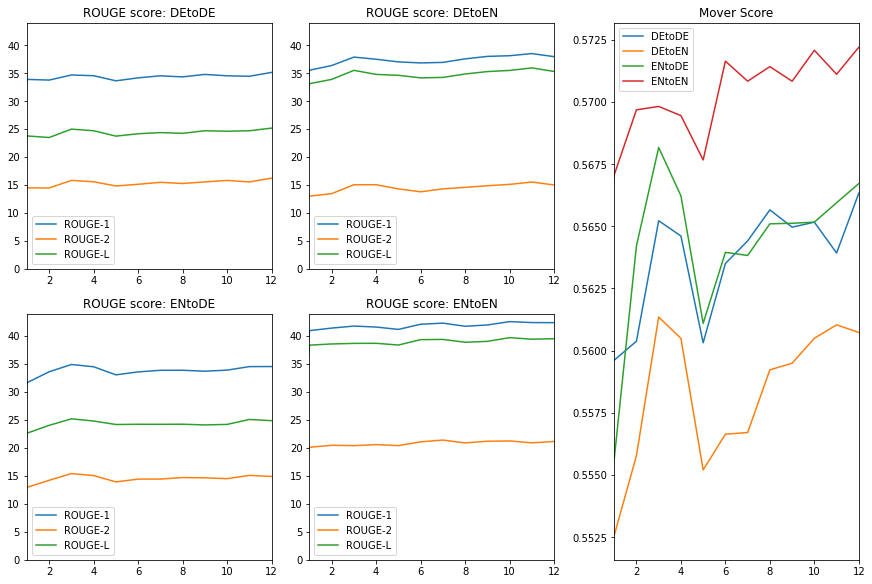

rouge_score max:  DEtoDE [11 11 11]
rouge_score max:  DEtoEN [10 10 10]
rouge_score max:  ENtoDE [2 2 2]
rouge_score max:  ENtoEN [9 6 9]


In [16]:
my_score = MyScore()
for i, (rouge_score, mover_score) in enumerate(scores):
    for token in language_token_order:
        print("[{}]----- {} -----".format(i, token))
        my_score(token, rouge_score[token].result(), mover_score[token].result())

    
my_score.plot()

## Final Result

### Load Model best epochs

In [13]:
model = model_loader.load_epoch(3)
result_full_ds_path = result_folder + "cdm_full_ds_3/"

In [14]:
summary_gen = SummaryGenerator(tokenizer, language_token_order, True)

In [15]:
predictions = summary_gen.generate_summaries(model, test_dataset, result_full_ds_path, use_break_point=False)

820
[830]: time generating 10 batches: 479.75492310523987
[840]: time generating 10 batches: 461.38999462127686
[850]: time generating 10 batches: 474.4225845336914
[860]: time generating 10 batches: 477.5620963573456
[870]: time generating 10 batches: 469.65979051589966
[880]: time generating 10 batches: 460.3269591331482
[890]: time generating 10 batches: 471.6628324985504
[900]: time generating 10 batches: 472.30277276039124
[910]: time generating 10 batches: 461.9974629878998
[920]: time generating 10 batches: 472.67488193511963
[930]: time generating 10 batches: 471.74862003326416
[940]: time generating 10 batches: 471.5117814540863
[950]: time generating 10 batches: 459.3520839214325
[960]: time generating 10 batches: 462.90211176872253
[970]: time generating 10 batches: 446.9603946208954
[980]: time generating 10 batches: 474.25424003601074
[990]: time generating 10 batches: 476.7798533439636
[1000]: time generating 10 batches: 482.1904492378235
[1010]: time generating 10 batche

## Final result  4 epochs

In [10]:
result_full_ds_path = result_folder + "cdm_full_ds_3/"
predictions_dict = {}
predictions = []

epoch_files = listdir(result_full_ds_path)
epoch_files.sort()
for i, file_name in enumerate(epoch_files):
    with open(result_full_ds_path + file_name, "rb") as file:
        [predictions.append(item) for item in pickle.load(file)]
        
predictions_dict[0] = predictions

In [11]:
len(predictions_dict[0])

45920

In [12]:
my_score = MyScore()
scores = get_scores(predictions_dict, 16)

Epoch: 0 done


In [13]:
for i, (rouge_score, mover_score) in enumerate(scores):
    for token in language_token_order:
        print("[{}]----- {} -----".format(i, token))
        my_score(token, rouge_score[token].result(), mover_score[token].result())
    break

[0]----- de_de -----
rouge1 = 33.76, 95% confidence [33.54, 34.01]
rouge2 = 14.90, 95% confidence [14.70, 15.11]
rougeLsum = 24.21, 95% confidence [23.99, 24.43]
Moverscore: 0.56
[0]----- en_de -----
rouge1 = 33.25, 95% confidence [33.05, 33.47]
rouge2 = 13.94, 95% confidence [13.76, 14.13]
rougeLsum = 23.92, 95% confidence [23.73, 24.11]
Moverscore: 0.56
[0]----- de_en -----
rouge1 = 36.19, 95% confidence [35.98, 36.39]
rouge2 = 13.90, 95% confidence [13.74, 14.07]
rougeLsum = 33.62, 95% confidence [33.42, 33.81]
Moverscore: 0.56
[0]----- en_en -----
rouge1 = 41.05, 95% confidence [40.82, 41.28]
rouge2 = 19.66, 95% confidence [19.41, 19.91]
rougeLsum = 38.30, 95% confidence [38.06, 38.55]
Moverscore: 0.57


In [14]:
print(my_score.get_latex_table("Result scores of the 5th epoch test data.", "final_results_cdm"))

0.5619398906588893
[33.76408724 14.903222   24.21029508]
[33.76408724 14.903222   24.21029508] [33.25071738 13.93912735 23.920458  ]
[0.98479539 0.93530965 0.98802835]
[41.04981345 19.6551197  38.29754308] [36.1934488  13.90136493 33.61547726]
[0.88169582 0.70726432 0.87774501]
{'Scores': ['ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'MoverScore'], 'German to German': [33.764087235761934, 14.903221995273109, 24.21029507783208, 0.5619398906588893], 'English to English': [41.04981344581348, 19.655119704338286, 38.297543075632454, 0.5674455228678368], 'English to German': ['33.25 (0.98)', '13.94 (0.94)', '23.92 (0.99)', 0.5615413153861653], 'German to English': ['36.19 (0.88)', '13.90 (0.71)', '33.62 (0.88)', 0.5566120918606353]}
\begin{table}[htb]
	\begin{center}
		\begin{tabular}{|l|l|l|l|l|}
			\hline
			Scores & German to German & English to English & English to German & German to English\\
			\hline\hline
			ROUGE-1 & 33.76 & 41.05 & 33.25 (0.98) & 36.19 (0.88)\\
			ROUGE-2 & 14.90 & 19.66 & 13.

## Final Results 12 epochs

In [22]:
result_full_ds_path = result_folder + "cdm_full_ds/"

In [25]:
predictions_dict = {}
predictions = []

epoch_files = listdir(result_full_ds_path)
epoch_files.sort()

for i, file_name in enumerate(epoch_files):
    with open(result_full_ds_path + file_name, "rb") as file:
        [predictions.append(item) for item in pickle.load(file)]

predictions_dict[0] = predictions

In [26]:
mover_score = MoverScore()
scores = get_scores(predictions_dict, 16)

Epoch: 0 done


In [29]:
my_score = MyScore()
for i, (rouge_score, mover_score) in enumerate(scores):
    for token in language_token_order:
        print("[{}]----- {} -----".format(i, token))
        my_score(token, rouge_score[token].result(), mover_score[token].result())
    break

[0]----- de_de -----
rouge1 = 34.30, 95% confidence [34.07, 34.54]
rouge2 = 15.39, 95% confidence [15.16, 15.59]
rougeLsum = 24.72, 95% confidence [24.50, 24.93]
Moverscore: 0.56
[0]----- en_de -----
rouge1 = 34.05, 95% confidence [33.84, 34.28]
rouge2 = 14.56, 95% confidence [14.38, 14.76]
rougeLsum = 24.54, 95% confidence [24.36, 24.74]
Moverscore: 0.56
[0]----- de_en -----
rouge1 = 37.35, 95% confidence [37.15, 37.54]
rouge2 = 14.77, 95% confidence [14.60, 14.95]
rougeLsum = 34.66, 95% confidence [34.47, 34.86]
Moverscore: 0.56
[0]----- en_en -----
rouge1 = 41.24, 95% confidence [41.00, 41.48]
rouge2 = 19.82, 95% confidence [19.54, 20.08]
rougeLsum = 38.51, 95% confidence [38.29, 38.77]
Moverscore: 0.57


In [30]:
print(my_score.get_latex_table("Result scores of the 5th epoch test data.", "final_results_cdm"))

0.5636423410250435
[34.29709949 15.38584237 24.72101411]
[34.29709949 15.38584237 24.72101411] [34.04807921 14.56256879 24.54305252]
[0.99273932 0.94649148 0.9928012 ]
[41.23841615 19.8160559  38.51172521] [37.35014715 14.77377656 34.65933973]
[0.90571246 0.74554577 0.8999685 ]
{'Scores': ['ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'MoverScore'], 'German to German': [34.29709949054877, 15.385842367775727, 24.72101411138054, 0.5636423410250435], 'English to English': [41.238416146669245, 19.816055899300146, 38.51172520956734, 0.5681128579856144], 'English to German': ['34.05 (0.99)', '14.56 (0.95)', '24.54 (0.99)', 0.5633645559368039], 'German to English': ['37.35 (0.91)', '14.77 (0.75)', '34.66 (0.90)', 0.5589729189144175]}
\begin{table}[htb]
	\begin{center}
		\begin{tabular}{|l|l|l|l|l|}
			\hline
			Scores & German to German & English to English & English to German & German to English\\
			\hline\hline
			ROUGE-1 & 34.30 & 41.24 & 34.05 (0.99) & 37.35 (0.91)\\
			ROUGE-2 & 15.39 & 19.82 & 14.5